In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

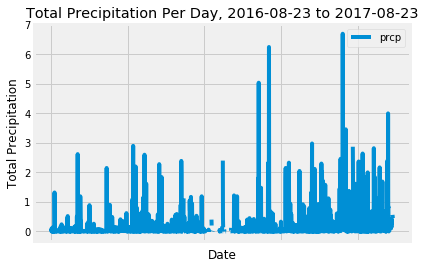

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
twelve_months = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prec_data = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >= twelve_months).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(prec_data)
prec_df.set_index('date',inplace=True)

# Sort the dataframe by date
prec_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot.line()
plt.ylabel('Total Precipitation')
plt.xlabel("Date")
plt.title("Total Precipitation Per Day, 2016-08-23 to 2017-08-23")

plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
count = prec_df['prcp'].count()
mean = prec_df['prcp'].mean()
std = prec_df['prcp'].std()
min = prec_df['prcp'].min()
first = prec_df['prcp'].quantile(.25)
second = prec_df['prcp'].quantile(.50)
third = prec_df['prcp'].quantile(.75)
max = prec_df['prcp'].max()

summary_df = pd.DataFrame({
    "precipitation":{"count":count,
                     "mean":mean,
                    "std":std,
                    "min":min,
                    "25%":first,
                    "50%":second,
                    "75%":third,
                    "max":max}
})

summary_df

,precipitation
25%,0.000000
50%,0.020000
75%,0.130000
count,2021.000000
max,6.700000
mean,0.177279
min,0.000000
std,0.461190


In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station))
for i in stations:
    print(i)

(9,)


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())

for i in active:
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_details = session.query(func.min(Measurement.tobs),
                               func.max(Measurement.tobs),
                               func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281")

for i in active_details:
    print(i)

(54.0, 85.0, 71.66378066378067)


Text(0.5, 1.0, 'Temperature Frequency at USC00519281')

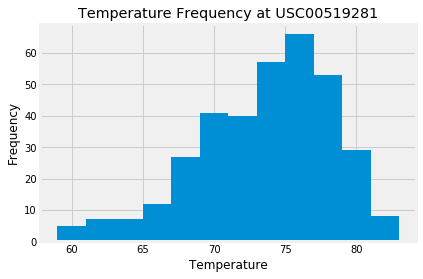

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data = session.query(Measurement.tobs,Measurement.date).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= twelve_months).all()

station_df = pd.DataFrame(station_data)
station_df.set_index('date',inplace=True)
station_df.sort_values(by=['date'])
station_df


# Use Pandas Plotting with Matplotlib to plot the data
station_df.hist(bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Temperature Frequency at USC00519281")

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = (calc_temps('2015-01-01','2016-01-10'))
print(my_trip)
trip_data=[item for temp in my_trip for item in temp]

[(56.0, 73.77571601452199, 86.0)]


Text(0, 0.5, 'Temperature (F)')

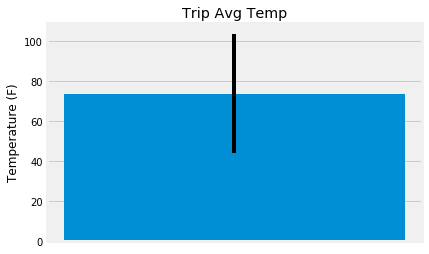

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_avg = trip_data[1]
temp_min = trip_data[0]
temp_max = trip_data[2]
err = temp_max - temp_min
x = np.arange(0,1)

plt.bar(x,temp_avg,yerr=err)
plt.xticks([])
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [func.sum(Measurement.prcp), Measurement.station, 
                            Station.name, Station.latitude, 
                            Station.longitude, Station.elevation]
my_trip_total = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2015-01-01', Measurement.date <= '2015-01-10').\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc())

for i in my_trip_total:
    print(i)

(1.7100000000000002, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(1.61, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(1.26, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(0.95, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(0.9400000000000001, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(0.78, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(0.76, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(0.0, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
